## Importing The libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from scipy import stats
from datetime import datetime 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import time

## Importing The Data

In [2]:
df = pd.read_csv("taxi-rides-classification.csv")
w = pd.read_csv("weather.csv")

## General Properties

In [3]:
df.head()

,distance,cab_type,time_stamp,destination,source,surge_multiplier,id,product_id,name,RideCategory
0,0.62,Uber,1.544770e+12,West End,Haymarket Square,1.0,c1b4a572-24b2-484d-aac5-b4f97b790480,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,unknown
1,2.27,Uber,1.543400e+12,Boston University,Beacon Hill,1.0,f9e7e7e6-b309-479b-9f90-bf26a1870c81,997acbb5-e102-41e1-b155-9df7de0a73f2,UberPool,cheap
2,2.00,Lyft,1.544920e+12,Back Bay,Haymarket Square,1.0,154e8438-46f5-4e5f-9872-15cc95e85eed,lyft,Lyft,moderate
3,3.98,Lyft,1.543620e+12,Financial District,Northeastern University,1.0,6bdc30a6-9a80-487b-914e-8d9b82ee4acb,lyft_plus,Lyft XL,expensive
4,1.49,Lyft,1.543580e+12,Back Bay,Northeastern University,1.0,0cb12fe9-cd72-4feb-b341-4a566b2e6643,lyft,Lyft,cheap


In [4]:
df[df.cab_type=='Uber'].RideCategory.value_counts()

moderate          92645
cheap             88008
expensive         62958
unknown           44135
very expensive    20723
Name: RideCategory, dtype: int64

In [5]:
df[df.cab_type=='Lyft'].RideCategory.value_counts()

moderate          85299
expensive         66134
cheap             63706
very expensive    30848
Name: RideCategory, dtype: int64

In [6]:
df.shape

(554456, 10)

In [7]:
df.dtypes

distance            float64
cab_type             object
time_stamp          float64
destination          object
source               object
surge_multiplier    float64
id                   object
product_id           object
name                 object
RideCategory         object
dtype: object

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554456 entries, 0 to 554455
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   distance          554456 non-null  float64
 1   cab_type          554456 non-null  object 
 2   time_stamp        554456 non-null  float64
 3   destination       554456 non-null  object 
 4   source            554456 non-null  object 
 5   surge_multiplier  554456 non-null  float64
 6   id                554456 non-null  object 
 7   product_id        554456 non-null  object 
 8   name              554456 non-null  object 
 9   RideCategory      554456 non-null  object 
dtypes: float64(3), object(7)
memory usage: 42.3+ MB


#### cab_type : is coming as object. Since cabtype is a either uber or lyft we can apply one hot encoding method to it. 
#### time_stamp : is coming as float64. Since timestamp indcates date so we can convert it into datetime.
#### there is null values in price (we will handle it later after some invstigation)

In [9]:
# appling one hot encoding on cap_type column 
df = pd.get_dummies(df, columns=["cab_type"])

#### we replaced timestamp with date coulmn and hour so we are going to drop time stamp coulmn

In [10]:
# convert timestamp to datetime
df['time_stamp']=df['time_stamp'].astype('Int64')/1000
df['date'] = [datetime.fromtimestamp(x)for x in df['time_stamp']]

In [11]:
df.head(3)

,distance,time_stamp,destination,source,surge_multiplier,id,product_id,name,RideCategory,cab_type_Lyft,cab_type_Uber,date
0,0.62,1.544770e+09,West End,Haymarket Square,1.0,c1b4a572-24b2-484d-aac5-b4f97b790480,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,unknown,0,1,2018-12-14 08:46:40
1,2.27,1.543400e+09,Boston University,Beacon Hill,1.0,f9e7e7e6-b309-479b-9f90-bf26a1870c81,997acbb5-e102-41e1-b155-9df7de0a73f2,UberPool,cheap,0,1,2018-11-28 12:13:20
2,2.00,1.544920e+09,Back Bay,Haymarket Square,1.0,154e8438-46f5-4e5f-9872-15cc95e85eed,lyft,Lyft,moderate,1,0,2018-12-16 02:26:40


In [12]:
df = df.drop(['time_stamp'], axis = 1)

#### we made hour coulmn 

In [13]:
df['hour']=df.date.dt.hour

#### updated date coulmn 

In [14]:
df.date = df.date.dt.date
df['date'] = df['date'].astype('datetime64[ns]')

In [15]:
df.head(3)

,distance,destination,source,surge_multiplier,id,product_id,name,RideCategory,cab_type_Lyft,cab_type_Uber,date,hour
0,0.62,West End,Haymarket Square,1.0,c1b4a572-24b2-484d-aac5-b4f97b790480,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,unknown,0,1,2018-12-14,8
1,2.27,Boston University,Beacon Hill,1.0,f9e7e7e6-b309-479b-9f90-bf26a1870c81,997acbb5-e102-41e1-b155-9df7de0a73f2,UberPool,cheap,0,1,2018-11-28,12
2,2.00,Back Bay,Haymarket Square,1.0,154e8438-46f5-4e5f-9872-15cc95e85eed,lyft,Lyft,moderate,1,0,2018-12-16,2


## handing null values

#### we can that there is no null values of RideCategory come with our data

In [16]:
df[df.RideCategory.isnull()].head()

,distance,destination,source,surge_multiplier,id,product_id,name,RideCategory,cab_type_Lyft,cab_type_Uber,date,hour


## we don't need product id as name can replace it 

In [17]:
df = df.drop(['product_id'], axis = 1)

In [18]:
df.head()

,distance,destination,source,surge_multiplier,id,name,RideCategory,cab_type_Lyft,cab_type_Uber,date,hour
0,0.62,West End,Haymarket Square,1.0,c1b4a572-24b2-484d-aac5-b4f97b790480,Taxi,unknown,0,1,2018-12-14,8
1,2.27,Boston University,Beacon Hill,1.0,f9e7e7e6-b309-479b-9f90-bf26a1870c81,UberPool,cheap,0,1,2018-11-28,12
2,2.00,Back Bay,Haymarket Square,1.0,154e8438-46f5-4e5f-9872-15cc95e85eed,Lyft,moderate,1,0,2018-12-16,2
3,3.98,Financial District,Northeastern University,1.0,6bdc30a6-9a80-487b-914e-8d9b82ee4acb,Lyft XL,expensive,1,0,2018-12-01,1
4,1.49,Back Bay,Northeastern University,1.0,0cb12fe9-cd72-4feb-b341-4a566b2e6643,Lyft,cheap,1,0,2018-11-30,14


In [19]:
df.surge_multiplier.unique()

array([1.  , 1.75, 1.25, 2.5 , 1.5 , 2.  , 3.  ])

## invstigating name further more

### comparing name to see how it related to price in lyft cabs thats happend in Phase 1

In [20]:
df[df.cab_type_Uber==1].name.unique()

array(['Taxi', 'UberPool', 'Black SUV', 'UberX', 'UberXL', 'Black', 'WAV'],
      dtype=object)

In [21]:
df[df.cab_type_Uber==0].name.unique()

array(['Lyft', 'Lyft XL', 'Lux Black', 'Lux Black XL', 'Lux', 'Shared'],
      dtype=object)

In [22]:
df = df.assign(Lyft_Type = df[(df.cab_type_Uber==0)].name) 

### as expected the order was 
> 1- shared: Share a car with riders headed in the same direction at a discounted price. 

> 2- lyft: Standard Lyft car for up to 3* riders

> 3- lyft xl: SUV for up to 5* riders

> 4- lux: Luxury car for up to 3* riders

> 5- lux black: Premium black car service with leather seats for up to 3* riders

> 6- lux black xl: Premium black SUV with leather seats for up to 5* riders
###### we got the description from offical company website: https://help.lyft.com/hc/ru/articles/115012927427-Lyft-ride-modes-overview 

### comparing name to see how it related to price in Uber cabs

### as expected the order was 
> 1- UberPool: Shared rides, door to door or with a short walk     ($6-$10)

> 2- Taxi: Taxi rides    ($9-$11)

> 3- UberX: Affordable rides, all to yourself ($9-$12)

> 4- UberXL: Affordable rides for groups up to 5   ($15-$20)

> 5- WAV: Wheelchair-accessible rides ($30-$35)

> 6- black: Luxury rides with professional drivers  ($30-$40)

> 7- Black SUV: Luxury rides for 5 with professional drivers    ($42-$52)


###### we got the description from offical company website for boston city as these locations are in boston: https://www.uber.com/global/en/cities/boston/ 

In [23]:
lyft={'Lux Black XL':6,'Lux Black':5,'Lux':4,'Lyft XL':3,'Lyft':2,'Shared':1}
lyft_map=[{'col':'Lyft_Type','mapping':lyft}]

df['Lyft_Type']=df['name']
encodeing= ce.OrdinalEncoder(cols=['Lyft_Type'],return_df=True,mapping=lyft_map)
df=encodeing.fit_transform(df)
df.loc[df.Lyft_Type <1, 'Lyft_Type'] = 0

In [24]:
df.head()

,distance,destination,source,surge_multiplier,id,name,RideCategory,cab_type_Lyft,cab_type_Uber,date,hour,Lyft_Type
0,0.62,West End,Haymarket Square,1.0,c1b4a572-24b2-484d-aac5-b4f97b790480,Taxi,unknown,0,1,2018-12-14,8,0.0
1,2.27,Boston University,Beacon Hill,1.0,f9e7e7e6-b309-479b-9f90-bf26a1870c81,UberPool,cheap,0,1,2018-11-28,12,0.0
2,2.00,Back Bay,Haymarket Square,1.0,154e8438-46f5-4e5f-9872-15cc95e85eed,Lyft,moderate,1,0,2018-12-16,2,2.0
3,3.98,Financial District,Northeastern University,1.0,6bdc30a6-9a80-487b-914e-8d9b82ee4acb,Lyft XL,expensive,1,0,2018-12-01,1,3.0
4,1.49,Back Bay,Northeastern University,1.0,0cb12fe9-cd72-4feb-b341-4a566b2e6643,Lyft,cheap,1,0,2018-11-30,14,2.0


## we will perform ordinal encoding based on this information 

In [25]:
df = df.assign(Uber_Type = df[(df.cab_type_Uber==1)].name) 

In [26]:
uber={'Black SUV':7,'Black':6,'WAV':5,'UberXL':4,'UberX':3,'Taxi':2,'UberPool':1}
uber_map=[{'col':'Uber_Type','mapping':uber}]
df['Uber_Type']=df['name']
encodeing= ce.OrdinalEncoder(cols=['Uber_Type'],return_df=True,mapping=uber_map)
df=encodeing.fit_transform(df)
df.loc[df.Uber_Type <1, 'Uber_Type'] = 0

In [27]:
df.head()

,distance,destination,source,surge_multiplier,id,name,RideCategory,cab_type_Lyft,cab_type_Uber,date,hour,Lyft_Type,Uber_Type
0,0.62,West End,Haymarket Square,1.0,c1b4a572-24b2-484d-aac5-b4f97b790480,Taxi,unknown,0,1,2018-12-14,8,0.0,2.0
1,2.27,Boston University,Beacon Hill,1.0,f9e7e7e6-b309-479b-9f90-bf26a1870c81,UberPool,cheap,0,1,2018-11-28,12,0.0,1.0
2,2.00,Back Bay,Haymarket Square,1.0,154e8438-46f5-4e5f-9872-15cc95e85eed,Lyft,moderate,1,0,2018-12-16,2,2.0,0.0
3,3.98,Financial District,Northeastern University,1.0,6bdc30a6-9a80-487b-914e-8d9b82ee4acb,Lyft XL,expensive,1,0,2018-12-01,1,3.0,0.0
4,1.49,Back Bay,Northeastern University,1.0,0cb12fe9-cd72-4feb-b341-4a566b2e6643,Lyft,cheap,1,0,2018-11-30,14,2.0,0.0


### we don't name name coulmn anymore after the ordinal encoding proccess so we can drop it

In [28]:
df = df.drop(['name'], axis = 1)

# weather dataframe Exploration

In [29]:
w.head()

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,42.42,Back Bay,1.0,1012.14,0.1228,1545003901,0.77,11.25
1,42.43,Beacon Hill,1.0,1012.15,0.1846,1545003901,0.76,11.32
2,42.50,Boston University,1.0,1012.15,0.1089,1545003901,0.76,11.07
3,42.11,Fenway,1.0,1012.13,0.0969,1545003901,0.77,11.09
4,43.13,Financial District,1.0,1012.14,0.1786,1545003901,0.75,11.49


## General Properties

In [30]:
w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6276 entries, 0 to 6275
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   temp        6276 non-null   float64
 1   location    6276 non-null   object 
 2   clouds      6276 non-null   float64
 3   pressure    6276 non-null   float64
 4   rain        894 non-null    float64
 5   time_stamp  6276 non-null   int64  
 6   humidity    6276 non-null   float64
 7   wind        6276 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 392.4+ KB


#### time_stamp : is coming as float64. Since timestamp indcates date so we can convert it into datetime.
#### there is null values in rain (we will handle it later after some invstigation)

In [31]:
w["date"]=[datetime.fromtimestamp(x) for x in w['time_stamp']]

### we made hour coulmn

In [32]:
w = w.assign(hour = w.date.dt.hour) 

In [33]:
w['date'] = w['date'].dt.date
w['date'] = w['date'].astype('datetime64[ns]')

In [34]:
w.head()

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind,date,hour
0,42.42,Back Bay,1.0,1012.14,0.1228,1545003901,0.77,11.25,2018-12-17,1
1,42.43,Beacon Hill,1.0,1012.15,0.1846,1545003901,0.76,11.32,2018-12-17,1
2,42.50,Boston University,1.0,1012.15,0.1089,1545003901,0.76,11.07,2018-12-17,1
3,42.11,Fenway,1.0,1012.13,0.0969,1545003901,0.77,11.09,2018-12-17,1
4,43.13,Financial District,1.0,1012.14,0.1786,1545003901,0.75,11.49,2018-12-17,1


#### we replaced timestamp with date coulmn and hour so we are going to drop time stamp coulmn

In [35]:
w = w.drop(['time_stamp'],axis=1)

### handling rain nulls

In [36]:
w.rain.isnull().sum()

5382

### 85 % of weather data have null values in rain

In [37]:
w.rain.isnull().sum()/w.shape[0] *100

85.75525812619503

## we need to imputate the missing values of rain in each day
# we will use the K-Nearest Neighbors imputation method

In [38]:
tmp = w

#### KNN imputer does not recognize text data values, so we are going to drop date coulmn and work with time stamp coulmn

In [39]:
tmp = tmp.assign(month=tmp.date.dt.month)
tmp = tmp.assign(day=tmp.date.dt.day)
tmp = pd.get_dummies(tmp, columns=['location'])
tmp = tmp.drop(['date'],axis=1)
tmp = tmp.drop(['hour'],axis=1)

###  KNN Imptuer is a distance-based imputation method and it requires us to normalize our data. Otherwise, the different scales of our data will lead the KNN Imputer to generate biased replacements for the missing values. 

### we will use Scikit-Learn’s MinMaxScaler which will scale our variables to have values between 0 and 1.

In [40]:
scaler = MinMaxScaler()
tmp = pd.DataFrame(scaler.fit_transform(tmp), columns = tmp.columns)

w.rain=(w.rain-w.rain.min())/(w.rain.max()-w.rain.min())

### KNN Imputation

In [41]:
imputer = KNNImputer(n_neighbors=5)
tmp = pd.DataFrame(imputer.fit_transform(tmp),columns = tmp.columns)

In [42]:
tmp.isnull().sum()

temp                                0
clouds                              0
pressure                            0
rain                                0
humidity                            0
wind                                0
month                               0
day                                 0
location_Back Bay                   0
location_Beacon Hill                0
location_Boston University          0
location_Fenway                     0
location_Financial District         0
location_Haymarket Square           0
location_North End                  0
location_North Station              0
location_Northeastern University    0
location_South Station              0
location_Theatre District           0
location_West End                   0
dtype: int64

### merging weather data with imputed data 

In [43]:
w = pd.merge(w.loc[:,w.columns.isin( ['location','time_stamp','date','hour','rain'])], tmp.loc[:,tmp.columns.isin(['temp','clouds','pressure','rain','humidity','wind'])], 
             left_index=True, right_index=True)

In [44]:
w.head(1)

,location,rain_x,date,hour,temp,clouds,pressure,rain_y,humidity,wind
0,Back Bay,0.157079,2018-12-17,1,0.637049,1.0,0.509708,0.157079,0.592593,0.612633


In [45]:
data_merged= pd.merge(df, w, left_on=['source','date','hour'],right_on=['location','date','hour'], how='inner')

In [46]:
data_merged.head(1)

,distance,destination,source,surge_multiplier,id,RideCategory,cab_type_Lyft,cab_type_Uber,date,hour,Lyft_Type,Uber_Type,location,rain_x,temp,clouds,pressure,rain_y,humidity,wind
0,0.62,West End,Haymarket Square,1.0,c1b4a572-24b2-484d-aac5-b4f97b790480,unknown,0,1,2018-12-14,8,0.0,2.0,Haymarket Square,NaN,0.271584,0.59,0.990612,0.01663,0.518519,0.030184


In [47]:
data_merged.shape

(1010578, 20)

In [48]:
display(data_merged[data_merged.duplicated()])

,distance,destination,source,surge_multiplier,id,RideCategory,cab_type_Lyft,cab_type_Uber,date,hour,Lyft_Type,Uber_Type,location,rain_x,temp,clouds,pressure,rain_y,humidity,wind
442,2.27,Boston University,Beacon Hill,1.0,f9e7e7e6-b309-479b-9f90-bf26a1870c81,cheap,0,1,2018-11-28,12,0.0,1.0,Beacon Hill,NaN,0.386421,0.13,0.062513,0.002178,0.703704,0.294019
448,1.92,Northeastern University,Beacon Hill,1.0,3a3b4269-e09d-464f-8f03-9f05e91daa28,expensive,0,1,2018-11-28,12,0.0,6.0,Beacon Hill,NaN,0.386421,0.13,0.062513,0.002178,0.703704,0.294019
454,2.25,Boston University,Beacon Hill,1.0,3cb44f82-39c2-495e-8f93-d2472c69287b,expensive,1,0,2018-11-28,12,5.0,0.0,Beacon Hill,NaN,0.386421,0.13,0.062513,0.002178,0.703704,0.294019
460,2.32,Fenway,Beacon Hill,1.0,b0361b6a-7742-4891-9791-817abdca226a,cheap,0,1,2018-11-28,12,0.0,3.0,Beacon Hill,NaN,0.386421,0.13,0.062513,0.002178,0.703704,0.294019
466,2.45,South Station,Beacon Hill,1.0,6566b8fe-e9e0-4ecc-9af0-3267c06e6dcb,expensive,1,0,2018-11-28,12,5.0,0.0,Beacon Hill,NaN,0.386421,0.13,0.062513,0.002178,0.703704,0.294019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1008637,3.01,Fenway,West End,1.0,7e6f7ddc-e244-4b90-82fd-32697d345ae8,cheap,1,0,2018-11-28,9,1.0,0.0,West End,NaN,0.431126,0.56,0.073181,0.002152,0.629630,0.297373
1008650,2.14,South Station,West End,1.0,01ede40b-4037-44b3-8cef-c151ab629dd1,moderate,0,1,2018-11-28,9,0.0,4.0,West End,NaN,0.431126,0.56,0.073181,0.002152,0.629630,0.297373
1008663,0.76,Haymarket Square,West End,1.0,8c5865b3-31b9-4d23-9e76-357a49340e32,cheap,1,0,2018-11-28,9,2.0,0.0,West End,NaN,0.431126,0.56,0.073181,0.002152,0.629630,0.297373
1008676,2.98,Fenway,West End,1.0,d36e795e-3512-4e40-85b5-753a42132b6f,expensive,1,0,2018-11-28,9,5.0,0.0,West End,NaN,0.431126,0.56,0.073181,0.002152,0.629630,0.297373


In [49]:
data_merged = data_merged.drop_duplicates(keep="first")

In [50]:
data_merged.head()

,distance,destination,source,surge_multiplier,id,RideCategory,cab_type_Lyft,cab_type_Uber,date,hour,Lyft_Type,Uber_Type,location,rain_x,temp,clouds,pressure,rain_y,humidity,wind
0,0.62,West End,Haymarket Square,1.0,c1b4a572-24b2-484d-aac5-b4f97b790480,unknown,0,1,2018-12-14,8,0.0,2.0,Haymarket Square,NaN,0.271584,0.59,0.990612,0.01663,0.518519,0.030184
1,0.57,North Station,Haymarket Square,1.0,ee77d0b2-f004-4d6f-9286-b6bda4510a28,cheap,1,0,2018-12-14,8,1.0,0.0,Haymarket Square,NaN,0.271584,0.59,0.990612,0.01663,0.518519,0.030184
2,1.82,Back Bay,Haymarket Square,1.0,dd20033a-1a27-46c2-a14a-5868ec48f7a3,unknown,0,1,2018-12-14,8,0.0,2.0,Haymarket Square,NaN,0.271584,0.59,0.990612,0.01663,0.518519,0.030184
3,0.91,Beacon Hill,Haymarket Square,1.0,0ed7a95e-8d79-45e9-8ac0-276720d4b1ed,moderate,0,1,2018-12-14,8,0.0,6.0,Haymarket Square,NaN,0.271584,0.59,0.990612,0.01663,0.518519,0.030184
4,0.54,West End,Haymarket Square,1.0,573f524f-16c3-40af-a689-cecf934ff537,expensive,1,0,2018-12-14,8,6.0,0.0,Haymarket Square,NaN,0.271584,0.59,0.990612,0.01663,0.518519,0.030184


In [51]:
data_merged.drop(['destination','source','id'],axis=1,inplace=True)
data_merged.head()

,distance,surge_multiplier,RideCategory,cab_type_Lyft,cab_type_Uber,date,hour,Lyft_Type,Uber_Type,location,rain_x,temp,clouds,pressure,rain_y,humidity,wind
0,0.62,1.0,unknown,0,1,2018-12-14,8,0.0,2.0,Haymarket Square,NaN,0.271584,0.59,0.990612,0.01663,0.518519,0.030184
1,0.57,1.0,cheap,1,0,2018-12-14,8,1.0,0.0,Haymarket Square,NaN,0.271584,0.59,0.990612,0.01663,0.518519,0.030184
2,1.82,1.0,unknown,0,1,2018-12-14,8,0.0,2.0,Haymarket Square,NaN,0.271584,0.59,0.990612,0.01663,0.518519,0.030184
3,0.91,1.0,moderate,0,1,2018-12-14,8,0.0,6.0,Haymarket Square,NaN,0.271584,0.59,0.990612,0.01663,0.518519,0.030184
4,0.54,1.0,expensive,1,0,2018-12-14,8,6.0,0.0,Haymarket Square,NaN,0.271584,0.59,0.990612,0.01663,0.518519,0.030184


In [52]:
data_merged.drop(['location','rain_x'],axis=1,inplace=True)

In [53]:
data_merged.drop(['date'],axis=1,inplace=True)

In [54]:
data_merged.RideCategory.unique()

array(['unknown', 'cheap', 'moderate', 'expensive', 'very expensive'],
      dtype=object)

In [55]:
data_merged.head()

,distance,surge_multiplier,RideCategory,cab_type_Lyft,cab_type_Uber,hour,Lyft_Type,Uber_Type,temp,clouds,pressure,rain_y,humidity,wind
0,0.62,1.0,unknown,0,1,8,0.0,2.0,0.271584,0.59,0.990612,0.01663,0.518519,0.030184
1,0.57,1.0,cheap,1,0,8,1.0,0.0,0.271584,0.59,0.990612,0.01663,0.518519,0.030184
2,1.82,1.0,unknown,0,1,8,0.0,2.0,0.271584,0.59,0.990612,0.01663,0.518519,0.030184
3,0.91,1.0,moderate,0,1,8,0.0,6.0,0.271584,0.59,0.990612,0.01663,0.518519,0.030184
4,0.54,1.0,expensive,1,0,8,6.0,0.0,0.271584,0.59,0.990612,0.01663,0.518519,0.030184


In [56]:
Ride={'very expensive':4,'expensive':3,'moderate':2,'cheap':1,'unknown':0}
Ride_Category_map=[{'col':'Ride_Category','mapping':Ride}]
data_merged['Ride_Category']=data_merged['RideCategory']
encodeing= ce.OrdinalEncoder(cols=['Ride_Category'],return_df=True,mapping=Ride_Category_map)
data_merged=encodeing.fit_transform(data_merged)

In [57]:
data_merged.drop(['RideCategory'],axis=1,inplace=True)

In [58]:
data_merged.head()

,distance,surge_multiplier,cab_type_Lyft,cab_type_Uber,hour,Lyft_Type,Uber_Type,temp,clouds,pressure,rain_y,humidity,wind,Ride_Category
0,0.62,1.0,0,1,8,0.0,2.0,0.271584,0.59,0.990612,0.01663,0.518519,0.030184,0
1,0.57,1.0,1,0,8,1.0,0.0,0.271584,0.59,0.990612,0.01663,0.518519,0.030184,1
2,1.82,1.0,0,1,8,0.0,2.0,0.271584,0.59,0.990612,0.01663,0.518519,0.030184,0
3,0.91,1.0,0,1,8,0.0,6.0,0.271584,0.59,0.990612,0.01663,0.518519,0.030184,2
4,0.54,1.0,1,0,8,6.0,0.0,0.271584,0.59,0.990612,0.01663,0.518519,0.030184,3


## Feature Selection

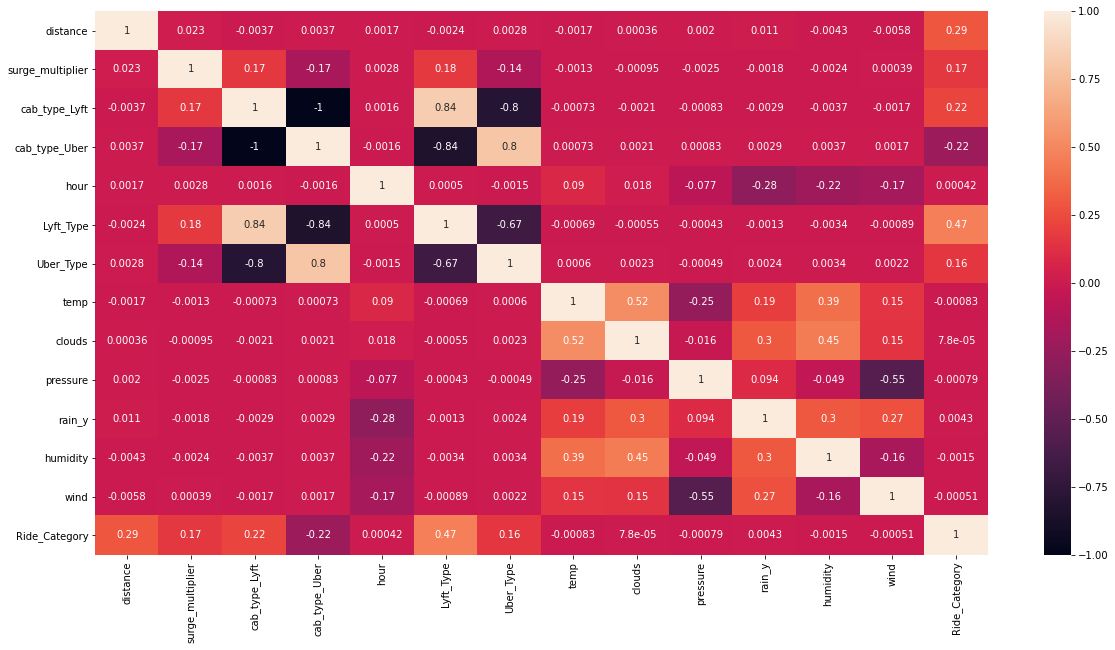

In [59]:
annot = True

# plotting the heatmap
ax, fig = plt.subplots(figsize=[20,10])
hm = sns.heatmap(data=data_merged.corr(),
                annot=annot)

plt.savefig('Classification_corr1.png')

plt.show()

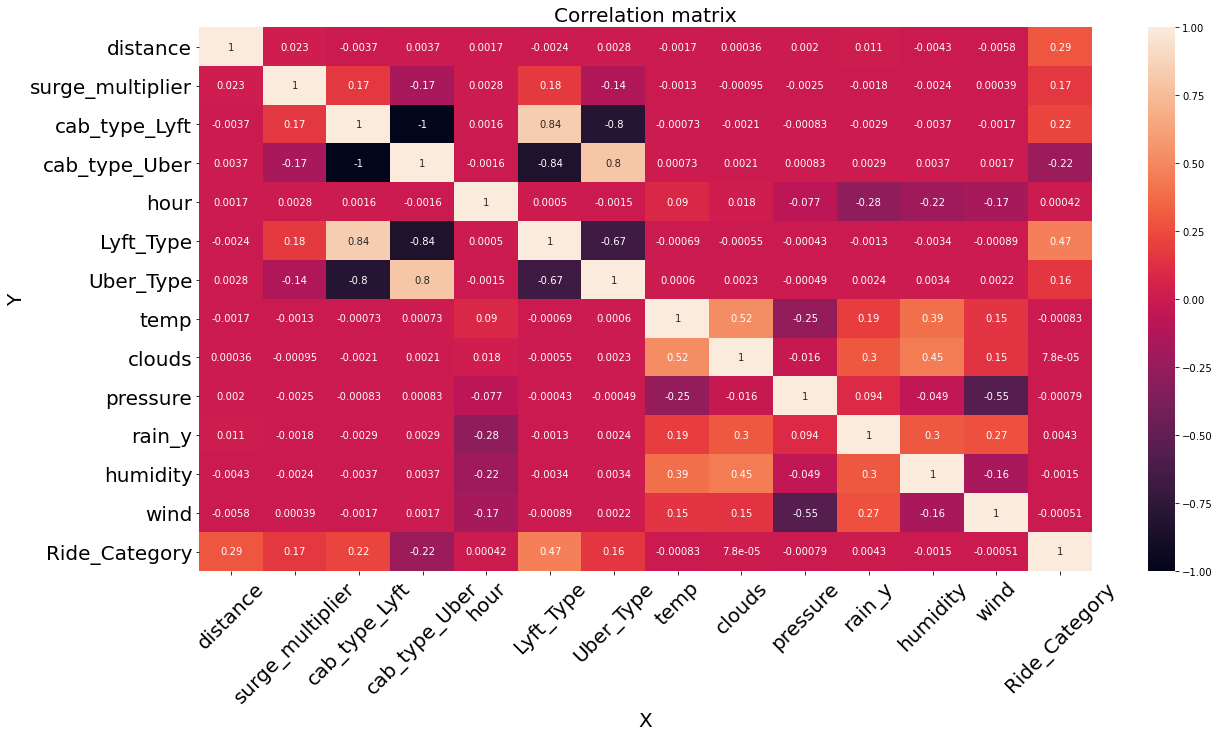

In [60]:
annot = True

# plotting the heatmap
ax, fig = plt.subplots(figsize=[20,10])
hm = sns.heatmap(data=data_merged.corr(),
                annot=annot)
plt.xlabel("X",fontsize=20)
plt.ylabel("Y",fontsize=20)
plt.xticks(rotation=45,fontsize=20)
plt.yticks(fontsize=20)
plt.title("Correlation matrix",fontdict={'fontsize':20})
# plt.savefig('Classification_corr_feature.png')

plt.show()

In [61]:
data_merged.head(1)

,distance,surge_multiplier,cab_type_Lyft,cab_type_Uber,hour,Lyft_Type,Uber_Type,temp,clouds,pressure,rain_y,humidity,wind,Ride_Category
0,0.62,1.0,0,1,8,0.0,2.0,0.271584,0.59,0.990612,0.01663,0.518519,0.030184,0


In [62]:
data_merged.drop(['hour','temp','clouds','humidity','wind'],axis=1,inplace=True)

In [63]:
data_merged.drop(['pressure'],axis=1,inplace=True)

In [64]:
data_merged.drop(['rain_y'],axis=1,inplace=True)

In [65]:
data_merged.head(5)

,distance,surge_multiplier,cab_type_Lyft,cab_type_Uber,Lyft_Type,Uber_Type,Ride_Category
0,0.62,1.0,0,1,0.0,2.0,0
1,0.57,1.0,1,0,1.0,0.0,1
2,1.82,1.0,0,1,0.0,2.0,0
3,0.91,1.0,0,1,0.0,6.0,2
4,0.54,1.0,1,0,6.0,0.0,3


# building model 

In [66]:
X=data_merged.iloc[:,:-1]
Y=data_merged.iloc[:,-1]

In [67]:
X.head()

,distance,surge_multiplier,cab_type_Lyft,cab_type_Uber,Lyft_Type,Uber_Type
0,0.62,1.0,0,1,0.0,2.0
1,0.57,1.0,1,0,1.0,0.0
2,1.82,1.0,0,1,0.0,2.0
3,0.91,1.0,0,1,0.0,6.0
4,0.54,1.0,1,0,6.0,0.0


In [68]:
Y.head()

0    0
1    1
2    0
3    2
4    3
Name: Ride_Category, dtype: int32

In [69]:
poly_features = PolynomialFeatures(degree=2)

In [70]:
accuracy=[]
train_time=[]
test_time=[]
models_name=[]
msq=[]

## ▪ Split your dataset into 80% training and 20% testing.

In [71]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20,shuffle=True,random_state=41)

## LogisticRegression Model

In [72]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
start_time = time.time()
classifier.fit(poly_features.fit_transform(x_train), y_train)
import pickle
with open("classification_logist",'wb') as files:
    pickle.dump(classifier,files)

logistic_train_time=(time.time() - start_time)
train_time.append(logistic_train_time)
models_name.append("Logistic Regression")

C:\Users\Toshiba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [73]:
# import  sklearn.metrics
# start_time = time.time()
# y_pred = classifier.predict(poly_features.fit_transform(x_test))
# logistic_prediction_time=(time.time() - start_time)
# test_time.append(logistic_prediction_time)
# msq.append( metrics.mean_squared_error(y_test, y_pred ))
# accuracy.append( metrics.accuracy_score(y_test, y_pred)*100)
# print('Mean Square Error', metrics.mean_squared_error(y_test, y_pred ))
# print ("Accuracy : ", metrics.accuracy_score(y_test, y_pred)*100)

## DecisionTreeClassifier Model

In [74]:
# 10 , 89
from sklearn.tree import DecisionTreeClassifier
start_time = time.time()
dtree_model = DecisionTreeClassifier(max_depth = 20).fit(x_train, y_train)
dtc_train_time=(time.time() - start_time)

train_time.append(dtc_train_time)
models_name.append("DecisionTreeClassifier")

print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
dtree_predictions = dtree_model.predict(x_test)
dtc_prediction_time=(time.time() - start_time)
print("--- %s seconds ---" % (time.time() - start_time))

test_time.append(dtc_prediction_time)
msq.append( metrics.mean_squared_error(y_test, dtree_predictions ))
accuracy.append( metrics.accuracy_score(y_test,dtree_predictions)*100)

print('Mean Square Error', metrics.mean_squared_error(y_test, dtree_predictions ))
print ("Accuracy : ", metrics.accuracy_score(y_test,dtree_predictions))
dtc_accuracy=metrics.accuracy_score(y_test,dtree_predictions)*100


--- 5.376356363296509 seconds ---
--- 0.12208271026611328 seconds ---
Mean Square Error 0.10880720284996227
Accuracy :  0.8930964360482255


In [75]:
import pickle
with open("Decisiontree",'wb') as files:
    pickle.dump(dtree_model,files)

In [76]:
# with open("Decisiontree",'rb') as f:
#     load_model=pickle.load(f)

##  KNeighborsClassifier Model

In [77]:
# from sklearn.neighbors import KNeighborsClassifier
# start_time = time.time()
# knn = KNeighborsClassifier(n_neighbors = 10).fit(x_train, y_train)
# knn_train_time=(time.time() - start_time)
# # creating a confusion matrix
# start_time = time.time()
# knn_predictions = knn.predict(x_test)
# knn_prediction_time=(time.time() - start_time)
# print('Mean Square Error', metrics.mean_squared_error(y_test, knn_predictions ))
# print ("Accuracy : ",  metrics.accuracy_score(y_test,knn_predictions))
# knn_accuracy= metrics.accuracy_score(y_test,knn_predictions)*100

# train_time.append(knn_train_time)
# models_name.append("KNeighborsClassifier")
# test_time.append(knn_prediction_time)
# msq.append(  metrics.mean_squared_error(y_test, knn_predictions ))
# accuracy.append(knn_accuracy)



## GaussianNB Model

In [78]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
start_time = time.time()
gnb.fit(x_train, y_train)
gaussian_train_time=(time.time() - start_time)
# making predictions on the testing set
start_time = time.time()
y_pred = gnb.predict(x_test)
gaussian_prediction_time=(time.time() - start_time)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred)*100)
gaussian_accuracy=metrics.accuracy_score(y_test, y_pred)*100

train_time.append(gaussian_train_time)
models_name.append("GaussianNB")
test_time.append(gaussian_prediction_time)
msq.append( metrics.mean_squared_error(y_test, y_pred ))
accuracy.append( gaussian_accuracy)



Accuracy: 57.60731077279745


## RandomForestClassifier Models with different hyper paramters 

In [79]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=1,max_features=6,bootstrap=True,max_depth=25)
 
# training the model on the train dataset
model.fit(x_train, y_train)
 
# predicting the output on the test dataset
y_pred = model.predict(x_test)

# printing the root mean squared error between real value and predicted value
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))



Accuracy: 0.8920971505373658


In [80]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=2,max_features=6,bootstrap=True,max_depth=10)
 
# training the model on the train dataset
model.fit(x_train, y_train)
 
# predicting the output on the test dataset
y_pred = model.predict(x_test)

# printing the root mean squared error between real value and predicted value
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8879151406744178


In [81]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=3,max_features=4,bootstrap=True)
start_time = time.time()
# training the model on the train dataset
model.fit(x_train, y_train)
import pickle
with open("randomforest",'wb') as files:
    pickle.dump(model,files)
randomfc_train_time=(time.time() - start_time)
# predicting the output on the test dataset
start_time = time.time()
y_pred = model.predict(x_test)
randomfc_prediction_time=(time.time() - start_time)

# printing the root mean squared error between real value and predicted value
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
randomforest_accuracy=metrics.accuracy_score(y_test, y_pred)*100

train_time.append(randomfc_train_time)
models_name.append("RandomForestClassifier")
test_time.append(randomfc_prediction_time)
msq.append( metrics.mean_squared_error(y_test, y_pred ))
accuracy.append(randomforest_accuracy)

Accuracy: 0.8930714539104541


## RandomForestClassifier's hyper paramters

In [82]:
print(model.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 4, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 3, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


## Try to Explain in details how hyperparameter tuning affected RandomForestClassifier models’performance.

In [83]:
# from sklearn.model_selection import GridSearchCV

# # Create the parameter grid based on the results of random search 
# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [10,15,20],
#     'max_features': [3,4],
#     'min_samples_leaf': [3, 4, 5,6,7,8],
#     'min_samples_split': [3,4,5,6],
#     'n_estimators': [30,50]
# }
# # Create a based model
# rf = RandomForestClassifier()
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, n_jobs = -1, verbose = 2)

# # Fit the grid search to the data
# grid_search.fit(x_train,y_train)

In [84]:
# best_grid = grid_search.best_estimator_
# y_pred = best_grid.predict(x_test)
# print (metrics.accuracy_score(y_test, y_pred))

## Ploting  accuracy , train_time ,test_time and Mean Square Error for different Models 

ValueError: shape mismatch: objects cannot be broadcast to a single shape

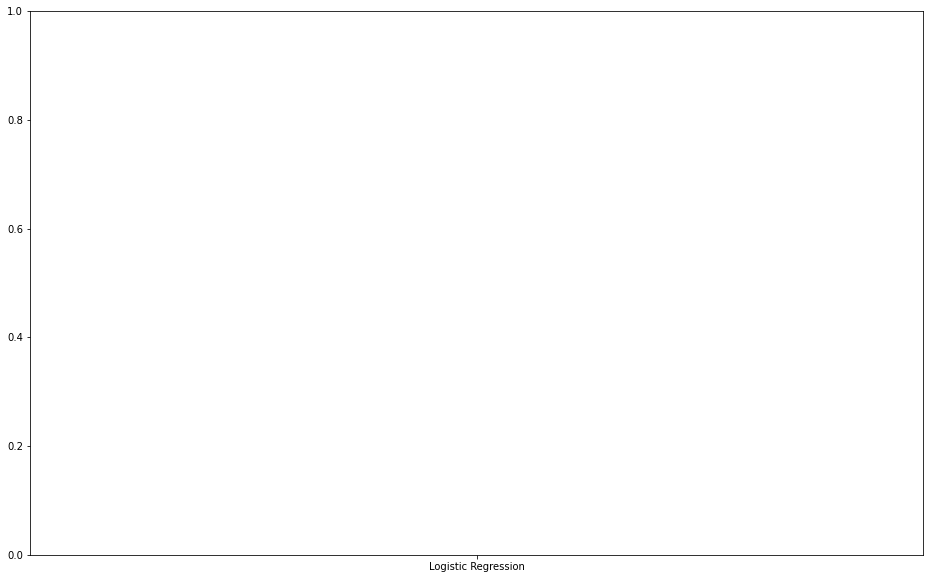

In [85]:
# accuracy , train_time ,test_time ,models_name ,msq

# accuracy bar char ploting 
plt_1 = plt.figure(figsize=(16, 10))
plt.bar(models_name,accuracy,
        width = 0.4)
plt.xlabel("Models Names",fontsize=20)
plt.ylabel("accuracy (%)",fontsize=20)
plt.xticks(rotation = 45,fontsize=20)
plt.yticks(fontsize=20)
plt.title("Classification Accuracy Summarize",fontdict={'fontsize':20})
# plt.savefig('Classification_Accuracy.png')
plt.show()

In [ ]:
plt_1 = plt.figure(figsize=(16, 10))
plt.bar(models_name,train_time,
        width = 0.4)
plt.xlabel("Models Names",fontsize=20)
plt.ylabel("Training Time",fontsize=20)
plt.xticks(rotation = 45,fontsize=20)
plt.yticks(fontsize=20)

plt.title("Total Training Time Summarize",fontdict={'fontsize':20})
# plt.savefig('Classification_Training Time.png')
plt.show()

In [ ]:
plt_1 = plt.figure(figsize=(16, 10))
plt.bar(models_name,test_time,
        width = 0.4)

plt.xlabel("Models Names",fontsize=20)
plt.ylabel("Testing Time",fontsize=20)
plt.xticks(rotation = 45,fontsize=20)
plt.yticks(fontsize=20)
plt.title("Total Testing Time Summarize",fontdict={'fontsize':20})
# plt.savefig('Classification_Testing Time.png')
plt.show()

In [ ]:
plt_1 = plt.figure(figsize=(16, 10))
plt.bar(models_name,msq,
        width = 0.4)
plt.xlabel("Models Names" ,fontsize=20)
plt.ylabel("Mean Square Error",fontsize=20)
plt.xticks(rotation=45,fontsize=20)
plt.yticks(fontsize=20)
plt.title("Mean Square Error Summarize",fontdict={'fontsize':20})
# plt.savefig('Classification_MSE.png')
plt.show()